# H5PIV

Velocity is a vector quantity. In the HDF file each component generally is stored as an individual data variable. To get the full vector in one variable the attribute `VelocityVector` can be called. Slicing this object will assigned it with the respectve arrays from the HDF datasets. In this case x- and y-velociy datasets are siced and merged into a `xr.Dataset`. The `VelocityVector` class is wrapped around the `xr.Dataset` class and has additional methods, like `compute_magnitude()`.

Note, that `VelocityVector` is not a property of `H5PIV` by default but is added afterwards, similar to how dataarray-ccessors are added to an `xr.DataArray`.

In [1]:
import h5rdmtoolbox as h5tbx
import numpy as np

c:\users\da4323\documents\programming\github\h5rdmtoolbox\h5rdmtoolbox\h5wrapper\h5piv.py:671: SpecialDatasetRegistrationWarning: registration of accessor <class 'h5rdmtoolbox.h5wrapper.h5piv.PIVDisplacementDataset'> under name 'DisplacementVector' for type <class 'h5rdmtoolbox.h5wrapper.h5piv.H5PIVGroup'> is overriding a preexisting attribute with the same name.
  class PIVDisplacementDataset(DisplacementDataset):


In [2]:
with h5tbx.tutorial.get_H5PIV('minimal_flow', mode='r') as h5:
    h5.dump()
    vel = h5.VelocityVector[:]

`VeloctyVector` has most properties, that `xr.Dataset has`, too:

In [3]:
vel

<xarray.Dataset>
Dimensions:  (z: 2, time: 5, y: 110, x: 127)
Coordinates:
  * z        (z) float32 -5.0 0.0
  * time     (time) float32 0.0 0.2 0.4 0.6 0.8
  * y        (y) float64 -15.22 -14.33 -13.44 -12.56 ... 79.0 79.89 80.78 81.67
  * x        (x) float64 -22.11 -21.22 -20.33 -19.44 ... 87.22 88.11 89.0 89.89
Data variables:
    u        (z, time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    v        (z, time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    units:      m/s
    long_name:  vector data

## Post-processing with `H5PIV`

Based on standard names velocity, velocity gradients and other variables are identified. Each group therefore should have only one velocity vector, otherwise it is not clear from which to compute e.g. the turbulent kinetic energy.<br>
From each group, multiple fluid-specific post-processing methods can be called. They store the result in the respective group if required data was correcly identified:

In [4]:
with h5tbx.tutorial.get_H5PIV('vortex_snapshot', mode='r+') as h5:
    h5.dump()

In [5]:
## Computing PIV uncertainty

Get an example HDF filename from the ILA vortex pair example (https://www.pivtec.com/pivview.html):

To compute the uncertainty of a PIV measurement, we need to gather some specific datasets, namely the at minimum the pixel coordinates, the displacements and the raw images. The class property `UncertaintyDataset` does this for us. Calling it will return a `xarray.Dataset` with the displacement variables.

Let's load the vortex example and fetch image A and imabe B:

In [6]:
with h5tbx.tutorial.get_H5PIV('vortex_snapshot', 'r+') as h5:
    disp = h5.DisplacementVector[:,:]
    imgA = h5.imgA[:,:]
    imgB = h5.imgB[:,:]
disp

<xarray.Dataset>
Dimensions:  (y: 29, x: 31)
Coordinates:
  * y        (y) float64 -464.0 -448.0 -432.0 -416.0 ... -64.0 -48.0 -32.0 -16.0
    iy       (y) int32 16 32 48 64 80 96 112 128 ... 368 384 400 416 432 448 464
  * x        (x) float64 16.0 32.0 48.0 64.0 80.0 ... 448.0 464.0 480.0 496.0
    ix       (x) int32 16 32 48 64 80 96 112 128 ... 400 416 432 448 464 480 496
    time     int32 0
    z        float64 0.0
Data variables:
    dx       (y, x) float32 nan nan nan nan nan ... 1.127 1.073 0.8495 0.7958
    dy       (y, x) float32 nan nan nan nan nan ... 0.08971 0.117 0.07952 0.1089
Attributes:
    units:      pixel
    long_name:  vector data

The uncertainty dataset has the coordinates `x` and `y`, the displacements arrays `dx` and `dy` but also the pixel coordinates `ix` and `iy`

Next, let's create a more or less random uncertainty method. In this example we do not compute the real error but assume one, just to explain the workflow of cumputing the uncertainty from the dataset:

In [7]:
def my_uncertainty_method(uds, imgA, imgB):
    """
    Dummy uncertainty method for this tutorial.
    Returns the same dataset but with added uncertainties
    
    Parameters
    ----------
    uds: XRUncertaintyDataset
        The uncertainty dataset containing, x, y, ix, iy, dx, dy, ...
    imgA: np.ndarray
        2d PIV image A. Will not be touch in this example
    imgB: np.ndarray
        2d PIV image B. Will not be touch in this example
        
    Returns
    -------
    uds: XRUncertaintyDataset    
    """
    import xarray as xr
    xerr = 0.05
    yerr = 0.075
    udx = np.abs(uds.dx)*xerr
    uds['udx'] = xr.DataArray(dims=uds.dx.dims, data=udx,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dx.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    udy = np.abs(uds.dy)*yerr
    uds['udy'] = xr.DataArray(dims=uds.dy.dims, data=udy,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dy.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    return uds

In [8]:
un = disp.compute_uncertainty(my_uncertainty_method, imgA, imgB)

The `XRUncertaintyDataset` not got some more datasets and the uncertainty `DataArray` `delta_dx` and `delta_dy`

Now, let's plot the magnitude of the displacements:

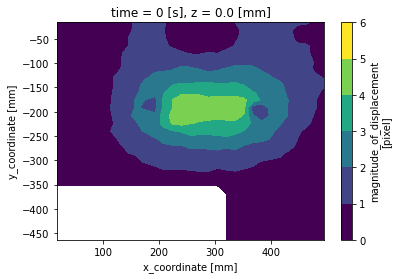

In [9]:
un.compute_magnitude()
_ = un.magnitude[:].plot.contourf(vmax=6, vmin=0)

Let's have a look at the `udx` dataset of the error without the extreme values which may be wrong:

Error in x-direction: 0.03808027505874634
Absolute relative error in x-direction: 0.05000000447034836


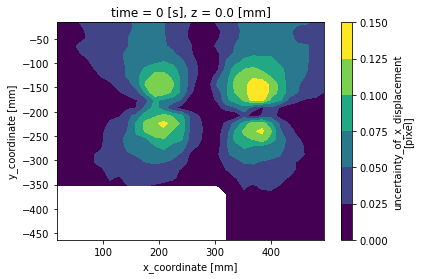

In [10]:
udx = un.get_by_standard_name('uncertainty_of_x_displacement')
_ = udx.where(np.abs(udx) < 20).plot.contourf()
print(f'Error in x-direction: {udx.mean().values}')
print(f'Absolute relative error in x-direction: {np.divide(udx, np.abs(un.dx)).mean().values}')

In [11]:
h5tbx.conventions.identifier.STRICT = False
# uncertainty_of_x_displacement is not part of the standard name table at this moment. 
# Don't check if standard names are in the respective table. this can be done by diabeling the "strictness" of checking standard names

In [12]:
with h5tbx.H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.create_group('uncertainty', overwrite=True)
    h5['uncertainty'].create_dataset('delta_dx', data=un.get_by_standard_name('uncertainty_of_x_displacement'), overwrite=True)
    h5['uncertainty'].create_dataset('delta_dy', data=un.get_by_standard_name('uncertainty_of_x_displacement'), overwrite=True)

Let's write the data into the HDF file:

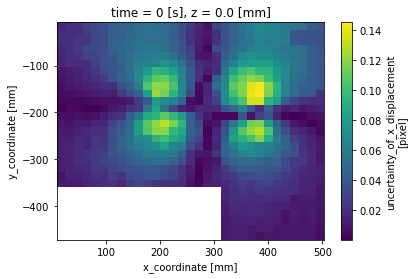

In [13]:
with h5tbx.H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.dump()
    h5.uncertainty.delta_dx[:,:].plot()